In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as np
plt.rcParams.update({'font.size': 25})

In [3]:
%cd ../../jax-morph

[Errno 2] No such file or directory: '../../jax-morph'
/n/home10/rdeshpande/morphogenesis/jax-morph/Ramya/paper


In [6]:
from jax import random, vmap
from jax_md import space, quantity, util
import jax_md.dataclasses as jdc

########## IMPORT JAX-MORPH FUNCTIONS ##########
################################################

from jax_morph.datastructures import SpaceFunc
from jax_morph.utils import _maybe_array, logistic
from jax_morph.simulation import simulation, sim_trajectory

# IMPORT STATE-CHANGING FUNCTIONS
from jax_morph.division_and_growth.cell_division import S_cell_division, S_cell_div_indep, S_cell_div_indep_MC
from jax_morph.division_and_growth.cell_growth import S_grow_cells

from jax_morph.mechanics.morse import S_mech_morse_relax
from jax_morph.cell_internals.stress import S_set_stress
from jax_morph.chemicals.secdiff import S_ss_chemfield

from jax_morph.cell_internals.divrates import S_set_divrate, div_nn
from jax_morph.cell_internals.secretion import sec_nn
from jax_morph.cell_internals.grad_estimate import S_chemical_gradients
from jax_morph.cell_internals.hidden_state import hidden_state_nn, S_hidden_state

from jax_morph.initial_states import init_state_grow

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate, draw_circles
from Ramya.mech_homogeneous_growth.chemical import S_fixed_chemfield

from functools import partial
import equinox as eqx
import haiku as hk

In [7]:
from Francesco.ALIFE_plots.alife_utils import default_params, build_sim_from_params, run_optimization

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
# For saving data
import pickle
import os

# Elongation Figures

In [36]:
# Elongation optimization loss curves
with open('../data/paper/elongation_decay_0.8_30_loss.pkl', 'rb') as handle:
    el_loss = pickle.load(handle)
with open('../data/paper/elongation_decay_0.8_30_params.pkl', 'rb') as handle:
    el_param = pickle.load(handle)

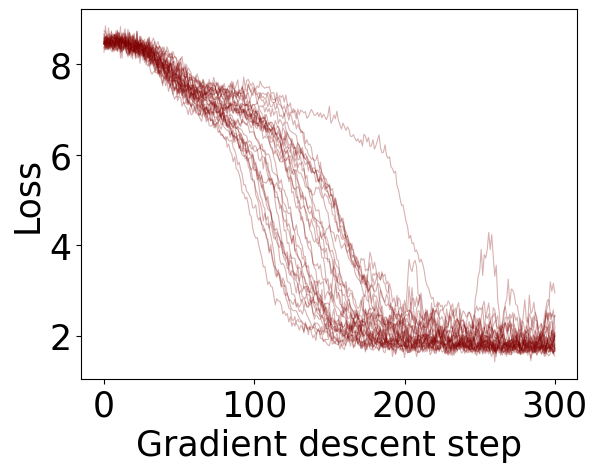

In [75]:
plt.plot(np.array(el_loss).T, color="maroon", alpha=0.3, linewidth=0.8);
plt.xlabel('Gradient descent step')
plt.ylabel('Loss');
plt.savefig('../data/paper/figures/elongation/loss.svg')

## Forward simulations

In [10]:
key = random.PRNGKey(0)
key, init_key = random.split(key)
Dparams, Dtrain_params = default_params(init_key)

In [11]:
key, subkey = random.split(key)
sim = build_sim_from_params(Dparams, Dtrain_params, subkey)

/n/home10/rdeshpande/.local/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:209: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/hidden_state.py:59: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/divrates.py:69: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future rel

In [50]:
# Get the params with the lowest loss at the end
opt_param = eqx.combine(el_param[np.argmin(np.array(el_loss)[:, -1])][-1], sim.params)

In [12]:
def position_sum_of_squares(state, coordinate=1):

    alive = state.celltype > 0

    m = np.sum((state.position[:, coordinate] * alive)**2)

    m = m / np.sum(alive)

    return m

In [16]:
# Run 100 different forward simulations with optimized results
def run_sim(key, sim, num_steps, params, loss_fn):
    sim_init, sim_step = simulation(sim.fstep, params, sim.fspace)
    fstate, _ = sim_trajectory(sim.istate, sim_init, sim_step, num_steps, key, history=False)
    return loss_fn(fstate)
run_sim_vmap = vmap(run_sim, in_axes=(0, None, None, None, None))

In [16]:
keys = random.split(key, 200)
unopt_losses = run_sim_vmap(keys[:100], sim, sim.params["ncells_add"], sim.params, position_sum_of_squares)
opt_losses = run_sim_vmap(keys[100:], sim, sim.params["ncells_add"], eqx.combine(el_param[0][-1], sim.params), position_sum_of_squares)

/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/secretion.py:79: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/hidden_state.py:86: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/divrates.py:95: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filt

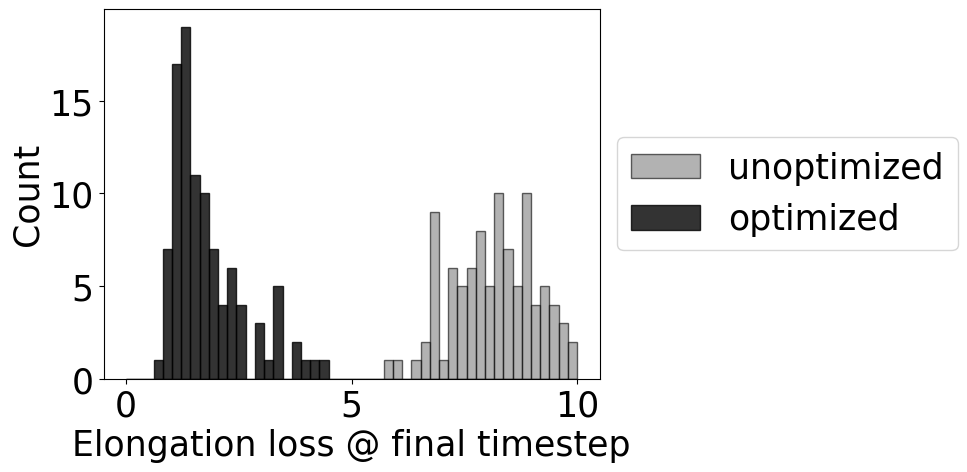

In [77]:
plt.hist(unopt_losses, edgecolor='black', label="unoptimized", color="gray", alpha=0.6, bins=np.linspace(0, 10, 50));
plt.hist(opt_losses, edgecolor='black', label="optimized", color="black", alpha=0.8, bins=np.linspace(0, 10, 50));
plt.xlabel("Elongation loss @ final timestep");
plt.ylabel("Count")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('../data/paper/figures/elongation/histograms_plot.svg')

In [22]:
key = random.PRNGKey(0)
key, init_key = random.split(key)
Dparams, Dtrain_params = default_params(init_key)
Dparams["hidden_state_decay"] = 0.8

In [23]:
key, subkey = random.split(key)
sim = build_sim_from_params(Dparams, Dtrain_params, subkey)

In [24]:
N_OPT = 1

EPOCHS = 150
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 100

LEARNING_RATE = 1e-3

METRIC_FN = position_sum_of_squares
SAVE_EVERY = 1

In [25]:
key, train_key = random.split(key)
loss_t, params_t, _ = run_optimization(train_key,
                                            sim,
                                            position_sum_of_squares,
                                            metric_type='cost',
                                            epochs=EPOCHS,
                                            episodes_per_update=EPISODES_PER_UPDATE,
                                            episodes_per_eval=EPISODES_PER_EVAL,
                                            learning_rate=LEARNING_RATE,
                                            save_every=SAVE_EVERY
                                            )

/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/secretion.py:79: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/hidden_state.py:86: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/divrates.py:95: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filt

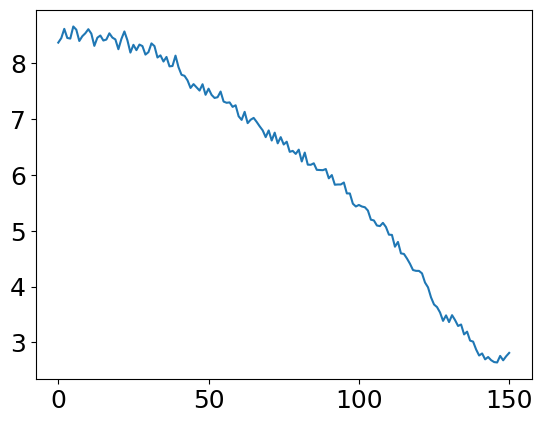

In [26]:
plt.plot(loss_t);

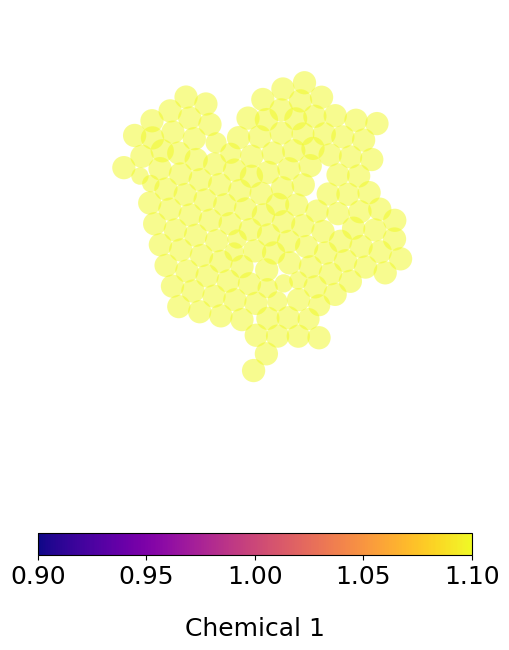

In [27]:
# Unoptimized state
sim_init, sim_step = simulation(sim.fstep, sim.params, sim.fspace)
fstate_unopt, _ = sim_trajectory(sim.istate, sim_init, sim_step, sim.params["ncells_add"], key, history=False)
draw_circles(fstate_unopt, fstate_unopt.celltype, cm=plt.cm.plasma, normalize=False, plt_cbar=True, cbar_title="Chemical 1", orientation="horizontal");
plt.savefig('../data/paper/figures/elongation/celltype_unopt.svg')

/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/secretion.py:79: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])


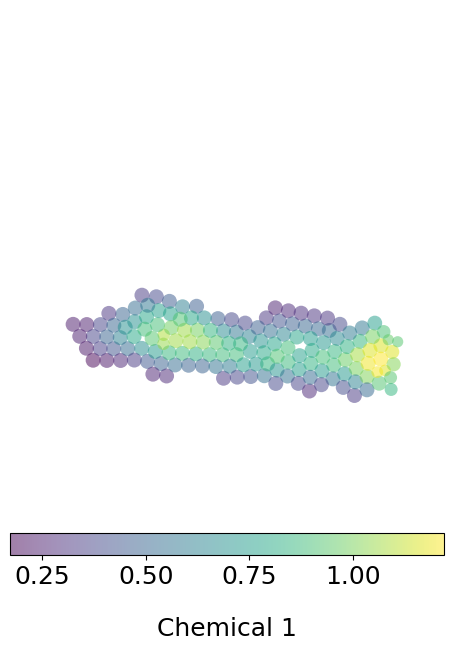

In [34]:
# Optimized state
sim_init, sim_step = simulation(sim.fstep, eqx.combine(params_t[-1], sim.params), sim.fspace)
fstate_opt, _ = sim_trajectory(sim.istate, sim_init, sim_step, sim.params["ncells_add"], key, history=False)
draw_circles(fstate_opt, fstate_opt.chemical[:, 0], cm=plt.cm.viridis, cbar_title="Chemical 1", orientation="horizontal", normalize=False, plt_cbar=True);
plt.savefig('../data/paper/figures/elongation/chemical1_opt.svg')

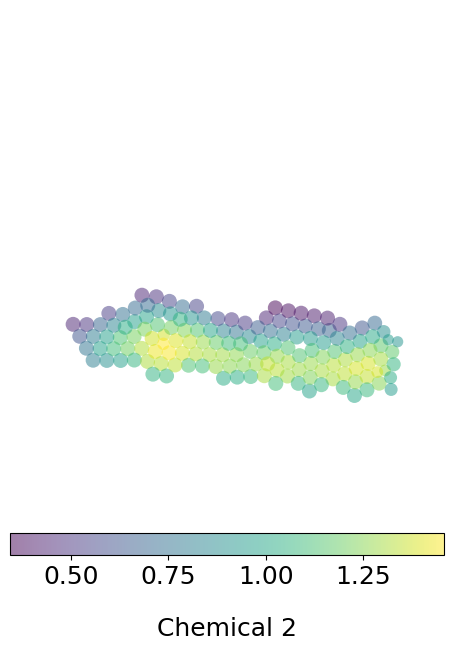

In [35]:
# Optimized state
sim_init, sim_step = simulation(sim.fstep, eqx.combine(params_t[-1], sim.params), sim.fspace)
fstate_opt, _ = sim_trajectory(sim.istate, sim_init, sim_step, sim.params["ncells_add"], key, history=False)
draw_circles(fstate_opt, fstate_opt.chemical[:, 1], cm=plt.cm.viridis, cbar_title="Chemical 2", orientation="horizontal", normalize=False, plt_cbar=True);
plt.savefig('../data/paper/figures/elongation/chemical2_opt.svg')

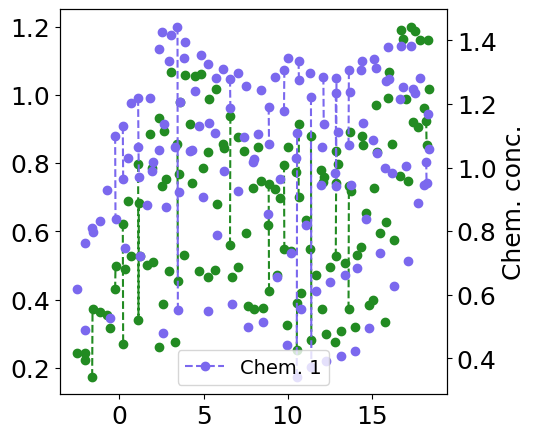

In [31]:
fig, ax1 = plt.subplots(1, figsize=(5, 5))
ax2 = ax1.twinx()
axes = [ax1, ax2]

smax = sim.params['sec_max']
color = {0:'forestgreen', 1:'mediumslateblue'}

for i, c in enumerate(fstate_opt.chemical.T):
    bins=np.linspace(fstate_opt.position[:,0].min(), fstate_opt.position[:,0].max(), 1000)
    #compute mean chemical for each bin
    mean_c = np.array([c[(fstate_opt.position[:,0] > bins[i]) & (fstate_opt.position[:,0] < bins[i+1])].mean() for i in range(len(bins)-1)])
    axes[i].plot(bins[:-1], mean_c, 'o--', color=color[i], label=f'Chem. {i}')
plt.xlabel('Binned y position')
plt.ylabel('Chem. conc.');
plt.legend(fontsize=14, loc='lower center');
plt.savefig('../data/paper/figures/elongation/binned_chemicals_opt.svg')

# V-shape Figures

In [9]:
# V-shape optimization loss curves
with open('Ramya/data/vshape_50_loss', 'rb') as handle:
    v_loss = pickle.load(handle)
with open('Ramya/data/vshape_50_params', 'rb') as handle:
    v_param = pickle.load(handle)

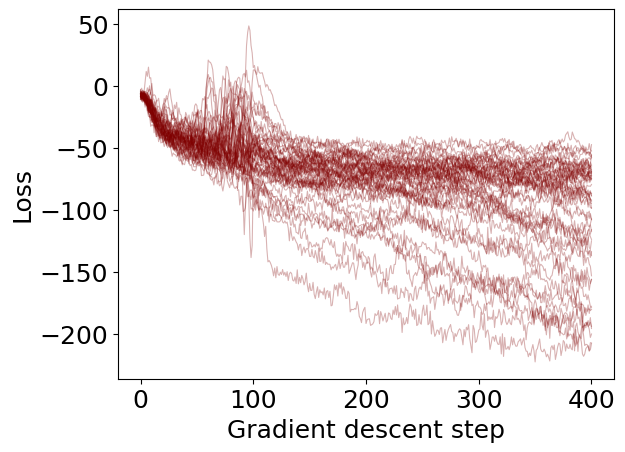

In [11]:
plt.plot(-np.array(v_loss).T, color="maroon", alpha=0.3, linewidth=0.8);
plt.xlabel('Gradient descent step')
plt.ylabel('Loss');
plt.savefig('../data/paper/figures/vshape/loss.svg')

In [20]:
from Francesco.ALIFE_plots.alife_utils import mask_metric
def v_mask(pos):
    '''
    Constrain cell growth in a V shape.
    '''
    return (pos[:,1]+1.5 > .5*np.abs(pos[:,0])) * (pos[:,1]+1.5 < 3.5+.5*np.abs(pos[:,0])) * (pos[:,1]>0.)


v_metric = mask_metric(v_mask)

In [19]:
key = random.PRNGKey(0)
key, init_key = random.split(key)
Dparams, Dtrain_params = default_params(init_key, 3)

In [20]:
key, subkey = random.split(key)
sim = build_sim_from_params(Dparams, Dtrain_params, subkey)
# Get highest reward param set
opt_param = v_param[np.argmax(np.array(v_loss)[:,-1])][-1]

In [22]:
keys = random.split(key, 200)
unopt_rewards = run_sim_vmap(keys[:100], sim, sim.params["ncells_add"], sim.params, v_metric)
opt_rewards = run_sim_vmap(keys[100:], sim, sim.params["ncells_add"], eqx.combine(opt_param, sim.params), v_metric)

/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/secretion.py:78: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/hidden_state.py:86: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/divrates.py:94: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filt

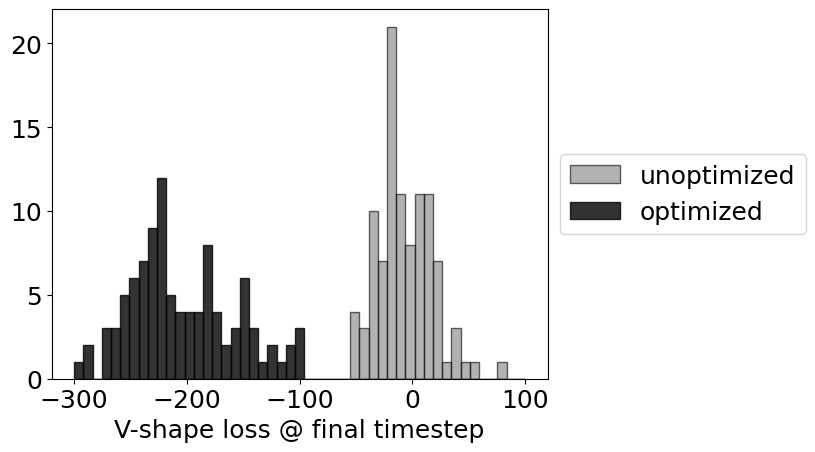

In [25]:
plt.hist(-unopt_rewards, edgecolor='black', label="unoptimized", color="gray", alpha=0.6, bins=np.linspace(-300, 100, 50));
plt.hist(-opt_rewards, edgecolor='black', label="optimized", color="black", alpha=0.8, bins=np.linspace(-300, 100, 50));
plt.xlabel("V-shape loss @ final timestep");
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('../data/paper/figures/vshape/histograms_plot.svg')

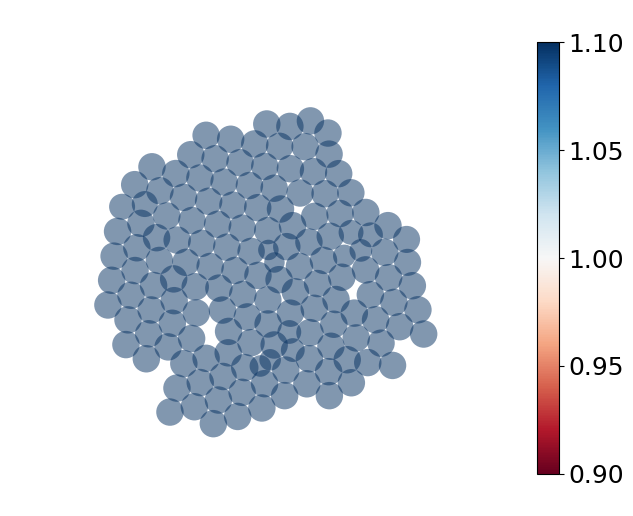

In [26]:
# Unoptimized state
sim_init, sim_step = simulation(sim.fstep, sim.params, sim.fspace)
fstate_unopt, _ = sim_trajectory(sim.istate, sim_init, sim_step, sim.params["ncells_add"], key, history=False)
draw_circles(fstate_unopt, fstate_unopt.celltype, cm=plt.cm.RdBu);
#plt.savefig('../data/paper/figures/vshape/celltype_unopt.svg')

/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/secretion.py:78: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])


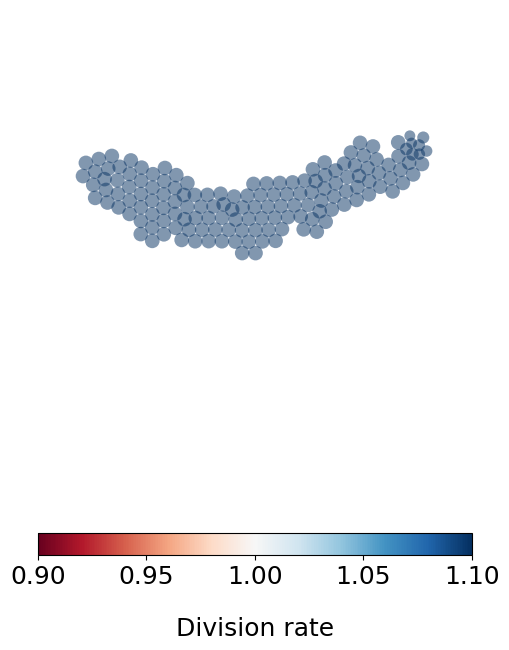

In [32]:
# Optimized state
sim_init, sim_step = simulation(sim.fstep, eqx.combine(opt_param, sim.params), sim.fspace)
fstate_opt, _ = sim_trajectory(sim.istate, sim_init, sim_step, sim.params["ncells_add"], key, history=False)
draw_circles(fstate_opt, fstate_opt.celltype, cm=plt.cm.RdBu, cbar_title="Division rate", orientation="horizontal", normalize=False, plt_cbar=True);
#plt.savefig('../data/paper/figures/vshape/celltype_opt.svg')

/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/secretion.py:79: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/hidden_state.py:86: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/divrates.py:95: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filt

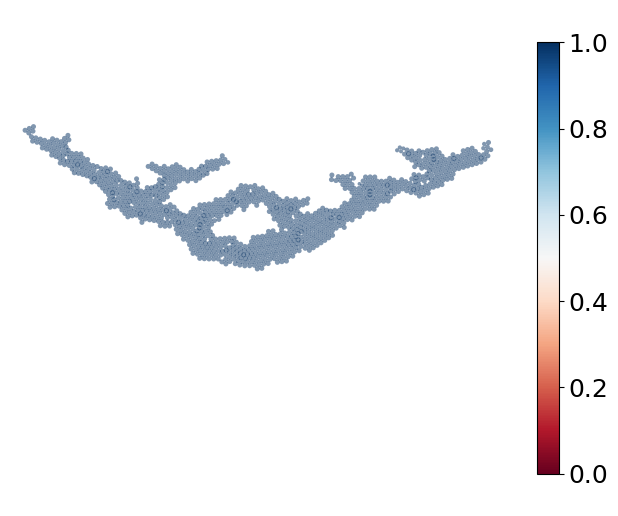

In [20]:
# Run for much larger number of timesteps
# Optimized state
sim_init, sim_step = simulation(sim.fstep, eqx.combine(opt_param, sim.params), sim.fspace)
fstate_opt, traj_opt = sim_trajectory(sim.istate, sim_init, sim_step, 1000, key, history=True)
draw_circles(fstate_opt, fstate_opt.celltype, cm=plt.cm.RdBu);
#plt.savefig('../data/paper/figures/vshape/celltype_opt_long.svg')

(<Figure size 800x800 with 2 Axes>, <Axes: >)

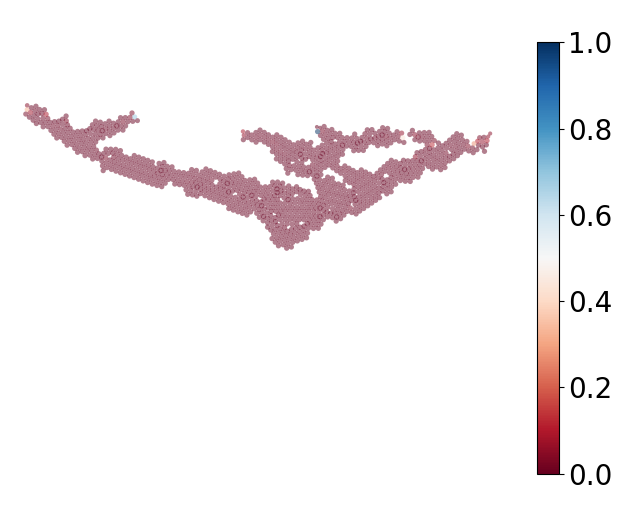

In [ ]:
draw_circles(fstate_opt, fstate_opt.divrate, cm=plt.cm.RdBu)

In [ ]:
def draw_circles(state, state_values, min_val = None, max_val = None, min_coord=None, max_coord=None, ax=None, cm=plt.cm.coolwarm, grid=False, plt_cbar=True, cbar_title=None, **kwargs):
    
    if None == ax:
        ax = plt.axes()
    

    alive_cells = state.celltype > 0

    state_values = np.float32(state_values)[alive_cells]    
            
    if min_val == None:
        state_values = (state_values-state_values.min()+1e-20)/(state_values.max()-state_values.min()+1e-20)
    else:
        state_values = (state_values-min_val+1e-20)/(max_val-min_val+1e-20)

    #only usable for two cell types
    color = cm(state_values)
    for cell,radius,c in zip(state.position[alive_cells],state.radius[alive_cells],color):
        circle = plt.Circle(cell, radius=radius, fc=c, alpha=.5, **kwargs)
        ax.add_patch(circle)
    
    
    ## calculate ax limits
    xmin = np.min(state.position[:,0][alive_cells])
    xmax = np.max(state.position[:,0][alive_cells])
    
    ymin = np.min(state.position[:,1][alive_cells])
    ymax = np.max(state.position[:,1][alive_cells])
    
    if min_coord == None:
        max_coord = max([xmax,ymax])+3
        min_coord = min([xmin,ymin])-3
    
    ax.set_xlim(min_coord,max_coord)
    ax.set_ylim(min_coord,max_coord)
    
    if ax == None:
        #scale x and y in the same way
        ax.set_aspect('equal', adjustable='box')

    #white bg color for ax
    ax.set_facecolor([1,1,1])

    if grid:
        ax.grid(alpha=.2)
    else:
        #remove axis spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        ax.set_xticks([])
        ax.set_yticks([])

    sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=min_val, vmax=max_val))
    sm._A = []
    if plt_cbar:
        cbar = plt.colorbar(sm, shrink=0.7, alpha=.5) # rule of thumb
        if cbar_title != None:
            cbar.set_label(cbar_title, labelpad=20)
    
    background_color = [56 / 256] * 3 
    if ax == None:       
        plt.gcf().patch.set_facecolor(background_color)
        plt.gcf().patch.set_alpha(0)

        plt.gcf().set_size_inches(8, 8)

    return plt.gcf(), ax

In [ ]:
# Plot chemical 1 every 10 steps from 100 to 200 steps
fig, ax = plt.subplots(5, 5, figsize=(20, 15))
for i in range(25):
    state = get_state(500 + 10*i, traj_opt)
    draw_circles(state, state.chemical[:, 1], cm=plt.cm.RdBu, plt_cbar=False, ax=ax[i//5, i%5], min_val=3.0, max_val=9.0)

In [ ]:
# decorator MUST be jax_md.dataclass instead of dataclasses.dataclass
# to make dataclass compatible with jax tree operations
@jdc.dataclass
class CellState:
    '''
    Dataclass containing the system state.

    STATE
    -----

    '''

    # STATE
    position:   util.Array
    celltype:   util.Array
    radius:     util.Array
    chemical:   util.Array
    chemgrad:   util.Array
    hidden_state: util.Array
    divrate:    util.Array
    key:        util.Array


    @classmethod
    def default_init(cls, n_dim=2, n_chem=1, hidden_size=10):
        '''
        Intializes a CellState with no cells (empty data structures, with correct shapes).
        

        Parameters
        ----------
        n_dim: int
            Number of spatial dimensions.
        n_chem: int
            Number of chemical species.

        Returns
        -------
        CellState
        '''

        assert n_dim == 2 or n_dim == 3, 'n_dim must be 2 or 3'
        assert n_chem > 0 and isinstance(n_chem, int), 'n_chem must be a positive integer'
        
        defaultstate = {
            'position'  :   np.empty(shape=(0, n_dim),              dtype=np.float32),
            'celltype'  :   np.empty(shape=(0,),                    dtype=np.int8),
            'radius'    :   np.empty(shape=(0,),                    dtype=np.float32),
            'chemical'  :   np.empty(shape=(0, n_chem),             dtype=np.float32),
            'chemgrad'  :   np.empty(shape=(0, int(n_dim*n_chem)),  dtype=np.float32),
            'hidden_state' : np.empty(shape=(0, hidden_size),       dtype=np.float32),
            'divrate'   :   np.empty(shape=(0,),                    dtype=np.float32),
            'key'       :   None,
        }


        return cls(**defaultstate)

In [ ]:
def get_state(t, traj):
    state = CellState(position=traj[0].position[t], celltype=traj[0].celltype[t], radius=traj[0].radius[t], chemical=traj[0].chemical[t], chemgrad=traj[0].chemgrad[t], divrate=traj[0].divrate[t], hidden_state=traj[0].hidden_state[t], key=traj[0].key)
    return state

In [27]:
from tqdm import tqdm
def kill_random(key, state, kill_rate=.3):
    '''Kill cells randomly'''

    ncells = int((state.celltype > 0).sum())
    nkill = int(ncells * kill_rate)

    #randomly select cells to kill
    kill_idx = random.choice(key, ncells, shape=(nkill,), replace=False)

    #get only cells not in kill_idx
    new_fields = {}
    for field in jdc.fields(state):

        value = getattr(state, field.name)

        if 'key' == field.name:
            new_fields[field.name] = state.key
        else:
            new_fields[field.name] = np.delete(value, kill_idx, axis=0)


    state = type(state)(**new_fields)

    return state


In [33]:
# Regeneration plots
kill_rates = np.linspace(.0, .9, 7)
n_avg = 15
METRIC_FN = v_metric
N_CELLS = int((fstate_opt.celltype > 0).sum())
n_kills = (kill_rates * N_CELLS).astype(int)
kill_rates = n_kills / N_CELLS #recalculate actual kill rates

regen_metrics_avg = []
regen_metrics_std = []

for kr, nk in zip(kill_rates, n_kills):
    reps = []
    for i in tqdm(np.arange(n_avg), desc='kill rate: ' + str(kr)):
        key, subkey, subkey_reg = random.split(key, 3)

        kill_state = kill_random(subkey, fstate_opt, kill_rate=kr)

        #forward pass - simulation
        sim_init, sim_step = simulation(sim.fstep, eqx.combine(opt_param, sim.params), sim.fspace)
        regen_state, _ = sim_trajectory(kill_state, sim_init, sim_step, ncells_add=nk, key=subkey_reg)

        reps += [float(METRIC_FN(regen_state))]

    reps = np.array(reps)
    regen_metrics_avg += [float(np.mean(reps))]
    regen_metrics_std += [float(np.std(reps))]

kill rate: 0.29999998:   0%|                                          | 0/15 [00:00<?, ?it/s]/n/home10/rdeshpande/.local/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:209: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/hidden_state.py:86: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/divr

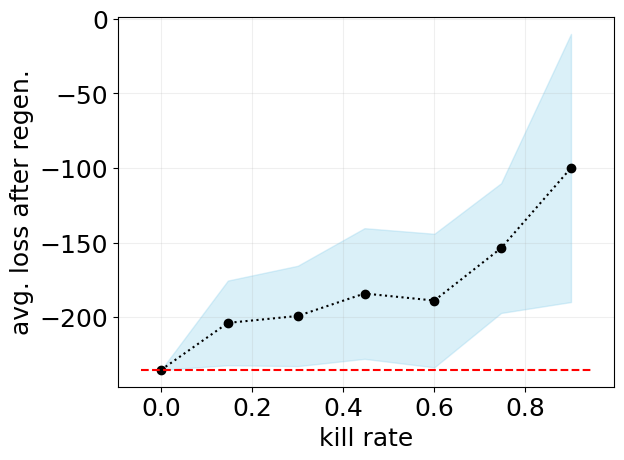

In [41]:
#plot results
regen_metrics_avg = np.array(regen_metrics_avg)
#plt.errorbar(log['kill_rates'], log['regen_metrics_avg'], yerr=log['regen_metrics_std'], fmt='o-')
plt.plot(kill_rates.tolist(), -1*regen_metrics_avg, 'ko:')
plt.fill_between(kill_rates.tolist(), np.array(-1*regen_metrics_avg) - np.array(regen_metrics_std), np.array(-1*regen_metrics_avg) + np.array(regen_metrics_std), alpha=.3, color='skyblue')

plt.hlines(-1*v_metric(fstate_opt), *plt.gca().get_xlim(), linestyles='dashed', color='r')

plt.xlabel('kill rate')
plt.ylabel('avg. loss after regen.')
plt.grid(alpha=.2)
plt.savefig('../data/paper/figures/vshape/regeneration.svg')

## V-shape mechanism

In [164]:
# Make range of N numbers from 5th to 95th percentile of value
from jax.nn import leaky_relu, softplus
def make_range(N, traj_vals):
    return np.linspace(np.percentile(traj_vals.flatten(), 5), np.percentile(traj_vals.flatten(), 95), N) 
# Internal guts of the networks
# Hidden
n_hidden = Dparams["hid_hidden"]
transform_mlp_out=None
def _hidden_nn(in_fields):
    mlp = hk.nets.MLP(n_hidden+[Dparams['hidden_state_size']],
                        activation=leaky_relu,
                        w_init=None,
                        activate_final=False
                        )
        
    out = mlp(in_fields)
    out = transform_mlp_out(out)

    return out
_hidden_nn = hk.without_apply_rng(hk.transform(_hidden_nn))

# Division
n_hidden_div, n_hidden_sec = Dparams["div_hidden"], Dparams["sec_hidden"]
transform_mlp_out = softplus
def _div_nn(in_fields):
    mlp = hk.nets.MLP(n_hidden_div+[1],
                      activation=leaky_relu,
                      activate_final=False,
                      w_init=hk.initializers.Constant(0.0),
                        )
        
    out = mlp(in_fields)
    out = transform_mlp_out(out)
    return out
_div_nn = hk.without_apply_rng(hk.transform(_div_nn))

# Secretion
transform_mlp_out=lambda x: x
def _sec_nn(in_fields):
    mlp = hk.nets.MLP(n_hidden_sec+[Dparams['n_chem']],
                        activation=leaky_relu,
                        activate_final=False,
                        w_init=hk.initializers.Orthogonal(),
                        )
        
    out = mlp(in_fields)
    out = transform_mlp_out(out)
    return out
_sec_nn = hk.without_apply_rng(hk.transform(_sec_nn))

In [326]:
# Create a cellstate template dictionary that contains all the fields
# and their shapes
from jax.tree_util import tree_leaves

def get_nn_output(traj, use_state_fields, params_to_use, cellstate_template, nn_func, nn_params, num=20):
    cellstate_dict = {}
    n_t, n_c = traj[0].radius.shape

    maskeds, maskeds_f = [], []
    masked_invs, masked_invs_f = [], []

    for field in jdc.fields(traj[0]):
        if field.name in use_state_fields:
            field_val = getattr(traj[0], field.name)
            field_val = np.reshape(field_val, (n_t*n_c, -1))
            field_val = field_val[~np.all(field_val == 0, axis=1)]
            cellstate_dict[field.name] = np.zeros((num**2, field_val.shape[-1]))
            if np.sum(cellstate_template[field.name]) == 0:
                cellstate_dict[field.name] = np.tile(np.median(field_val, axis=0), (num**2, 1))
            else:
                mask = np.tile(cellstate_template[field.name].astype(bool), (n_t, n_c, 1))
                masked = np.where(mask,np.atleast_3d(getattr(traj[0], field.name)), 0)
                masked = np.reshape(masked, (n_t*n_c, -1))
                masked = masked[~np.all(masked == 0, axis=1)]
                masked = masked[:, ~np.all(masked == 0, axis=0)]
                maskeds.append(masked)
                maskeds_f.append(field.name)

                
                masked_inv = np.where(~mask,np.atleast_3d(getattr(traj[0], field.name)), 0)
                if np.sum(np.abs(masked_inv)) > 0.0:
                    masked_inv = np.reshape(masked_inv, (n_t*n_c, -1))
                    masked_inv = masked_inv[~np.all(masked_inv == 0, axis=1)]
                    masked_invs.append(masked_inv)
                    masked_invs_f.append(field.name)
    if len(maskeds) > 1:
        xx = make_range(num, maskeds[0])
        yy = make_range(num, maskeds[1])
    else:
        xx = make_range(num, maskeds[0][:, 0])
        yy = make_range(num, maskeds[0][:, 1])
    x, y = np.meshgrid(xx, yy)
    
    if len(masked_invs) > 0:
        idx = np.argwhere(cellstate_template[masked_invs_f[0]] > 0)
        masked_inv_input = np.tile(np.median(masked_invs[0], axis=0), (num**2, 1))
        new_field = masked_inv_input.at[:, idx[0][0]].set(x.flatten())
        new_field = new_field.at[:, idx[1][0]].set(y.flatten())
        cellstate_dict[masked_invs_f[0]] = new_field
    else:
        if len(maskeds_f) > 1:
            cellstate_dict[maskeds_f[0]] = x.flatten()
            cellstate_dict[maskeds_f[1]] = y.flatten()
        else:
            cellstate_dict[maskeds_f[0]] = x.flatten()
            cellstate_dict[maskeds_f[0]] = y.flatten()
    input_data = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in tree_leaves(cellstate_dict)])
    plotting_data = (x, y)
    _ = _hidden_nn.init(key, np.ones(input_data.shape))
    hidden_output = _hidden_nn.apply(params_to_use["hidden_fn"].copy(), input_data)
    _ = nn_func.init(key, np.ones(np.array(hidden_output).shape))
    output = nn_func.apply(params_to_use[nn_params].copy(), hidden_output).flatten()
    return plotting_data, output


In [201]:
use_state_fields = ['radius', 'chemical', 'chemgrad', 'divrate']
cellstate_template = {}
for field in jdc.fields(traj_opt[0]):
    if field.name in use_state_fields:
        cellstate_template[field.name] = np.zeros((1, np.atleast_3d(getattr(traj_opt[0], field.name)).shape[-1]))

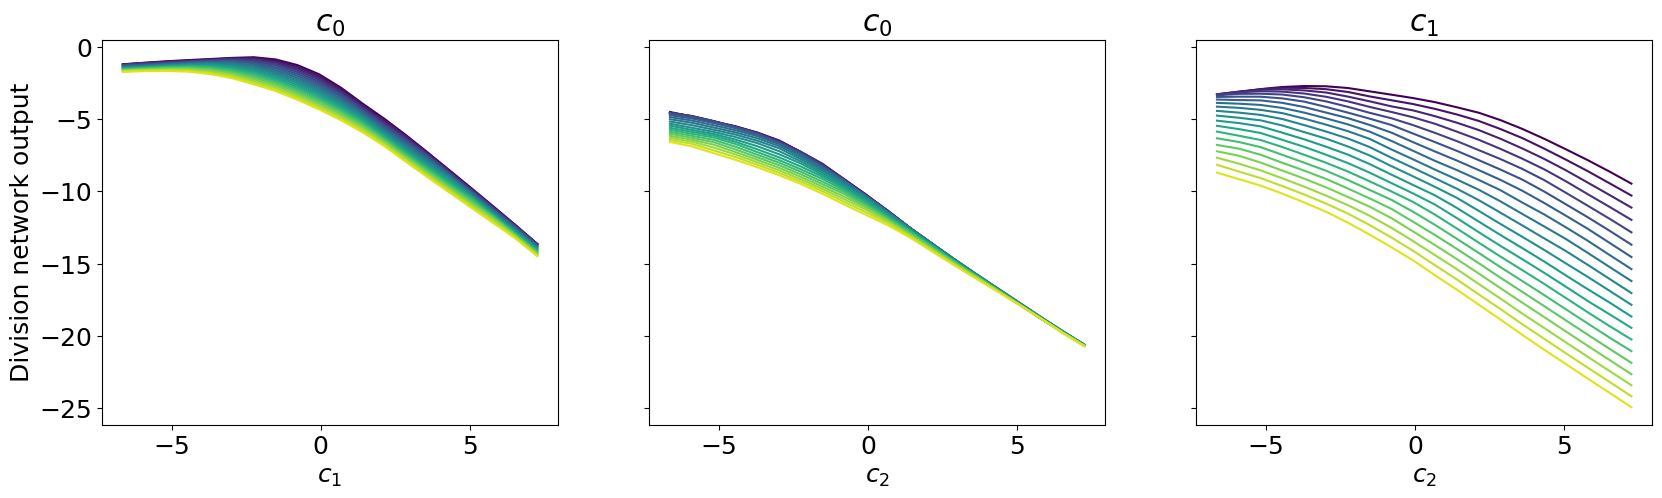

In [303]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
combinations = np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]])
for i in range(3):
    cellstate_template["chemical"] = np.array(combinations[i])
    cellstate_template["divrate"] = np.array([0.0])
    (x, y), div_output = get_nn_output(traj_opt, use_state_fields, opt_param.copy(), cellstate_template, _div_nn, "div_fn")
    for j in range(20):
        ax[i].plot(y.T[j],  div_output.reshape(20, 20).T[j], c=plt.cm.viridis(j/20));
    idx = np.argwhere(combinations[i] > 0)
    ax[i].set_title(r"$c_%s$" % idx[0][0])
    ax[i].set_xlabel(r"$c_%s$" % idx[1][0])
ax[0].set_ylabel("Division network output")
plt.savefig('../data/paper/figures/vshape/division_network_mechanism.svg')

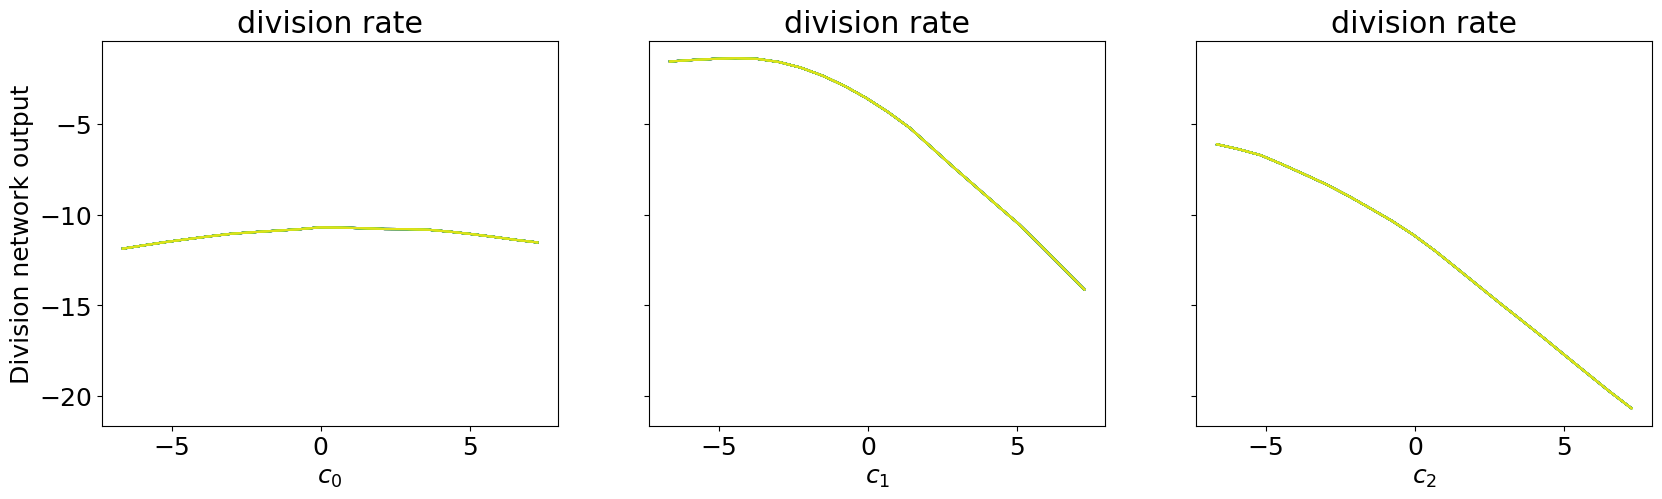

In [304]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
combinations = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
for i in range(3):
    cellstate_template["chemical"] = np.array(combinations[i])
    cellstate_template["divrate"] = np.array([1.0])
    (x, y), div_output = get_nn_output(traj_opt, use_state_fields, opt_param.copy(), cellstate_template, _div_nn, "div_fn")
    for j in range(20):
        ax[i].plot(y.T[j],  div_output.reshape(20, 20).T[j], c=plt.cm.viridis(j/20));
    ax[i].set_title("division rate")
    ax[i].set_xlabel(r"$c_%s$" % i)
ax[0].set_ylabel("Division network output")
plt.savefig('../data/paper/figures/vshape/division_network_mechanism2.svg')

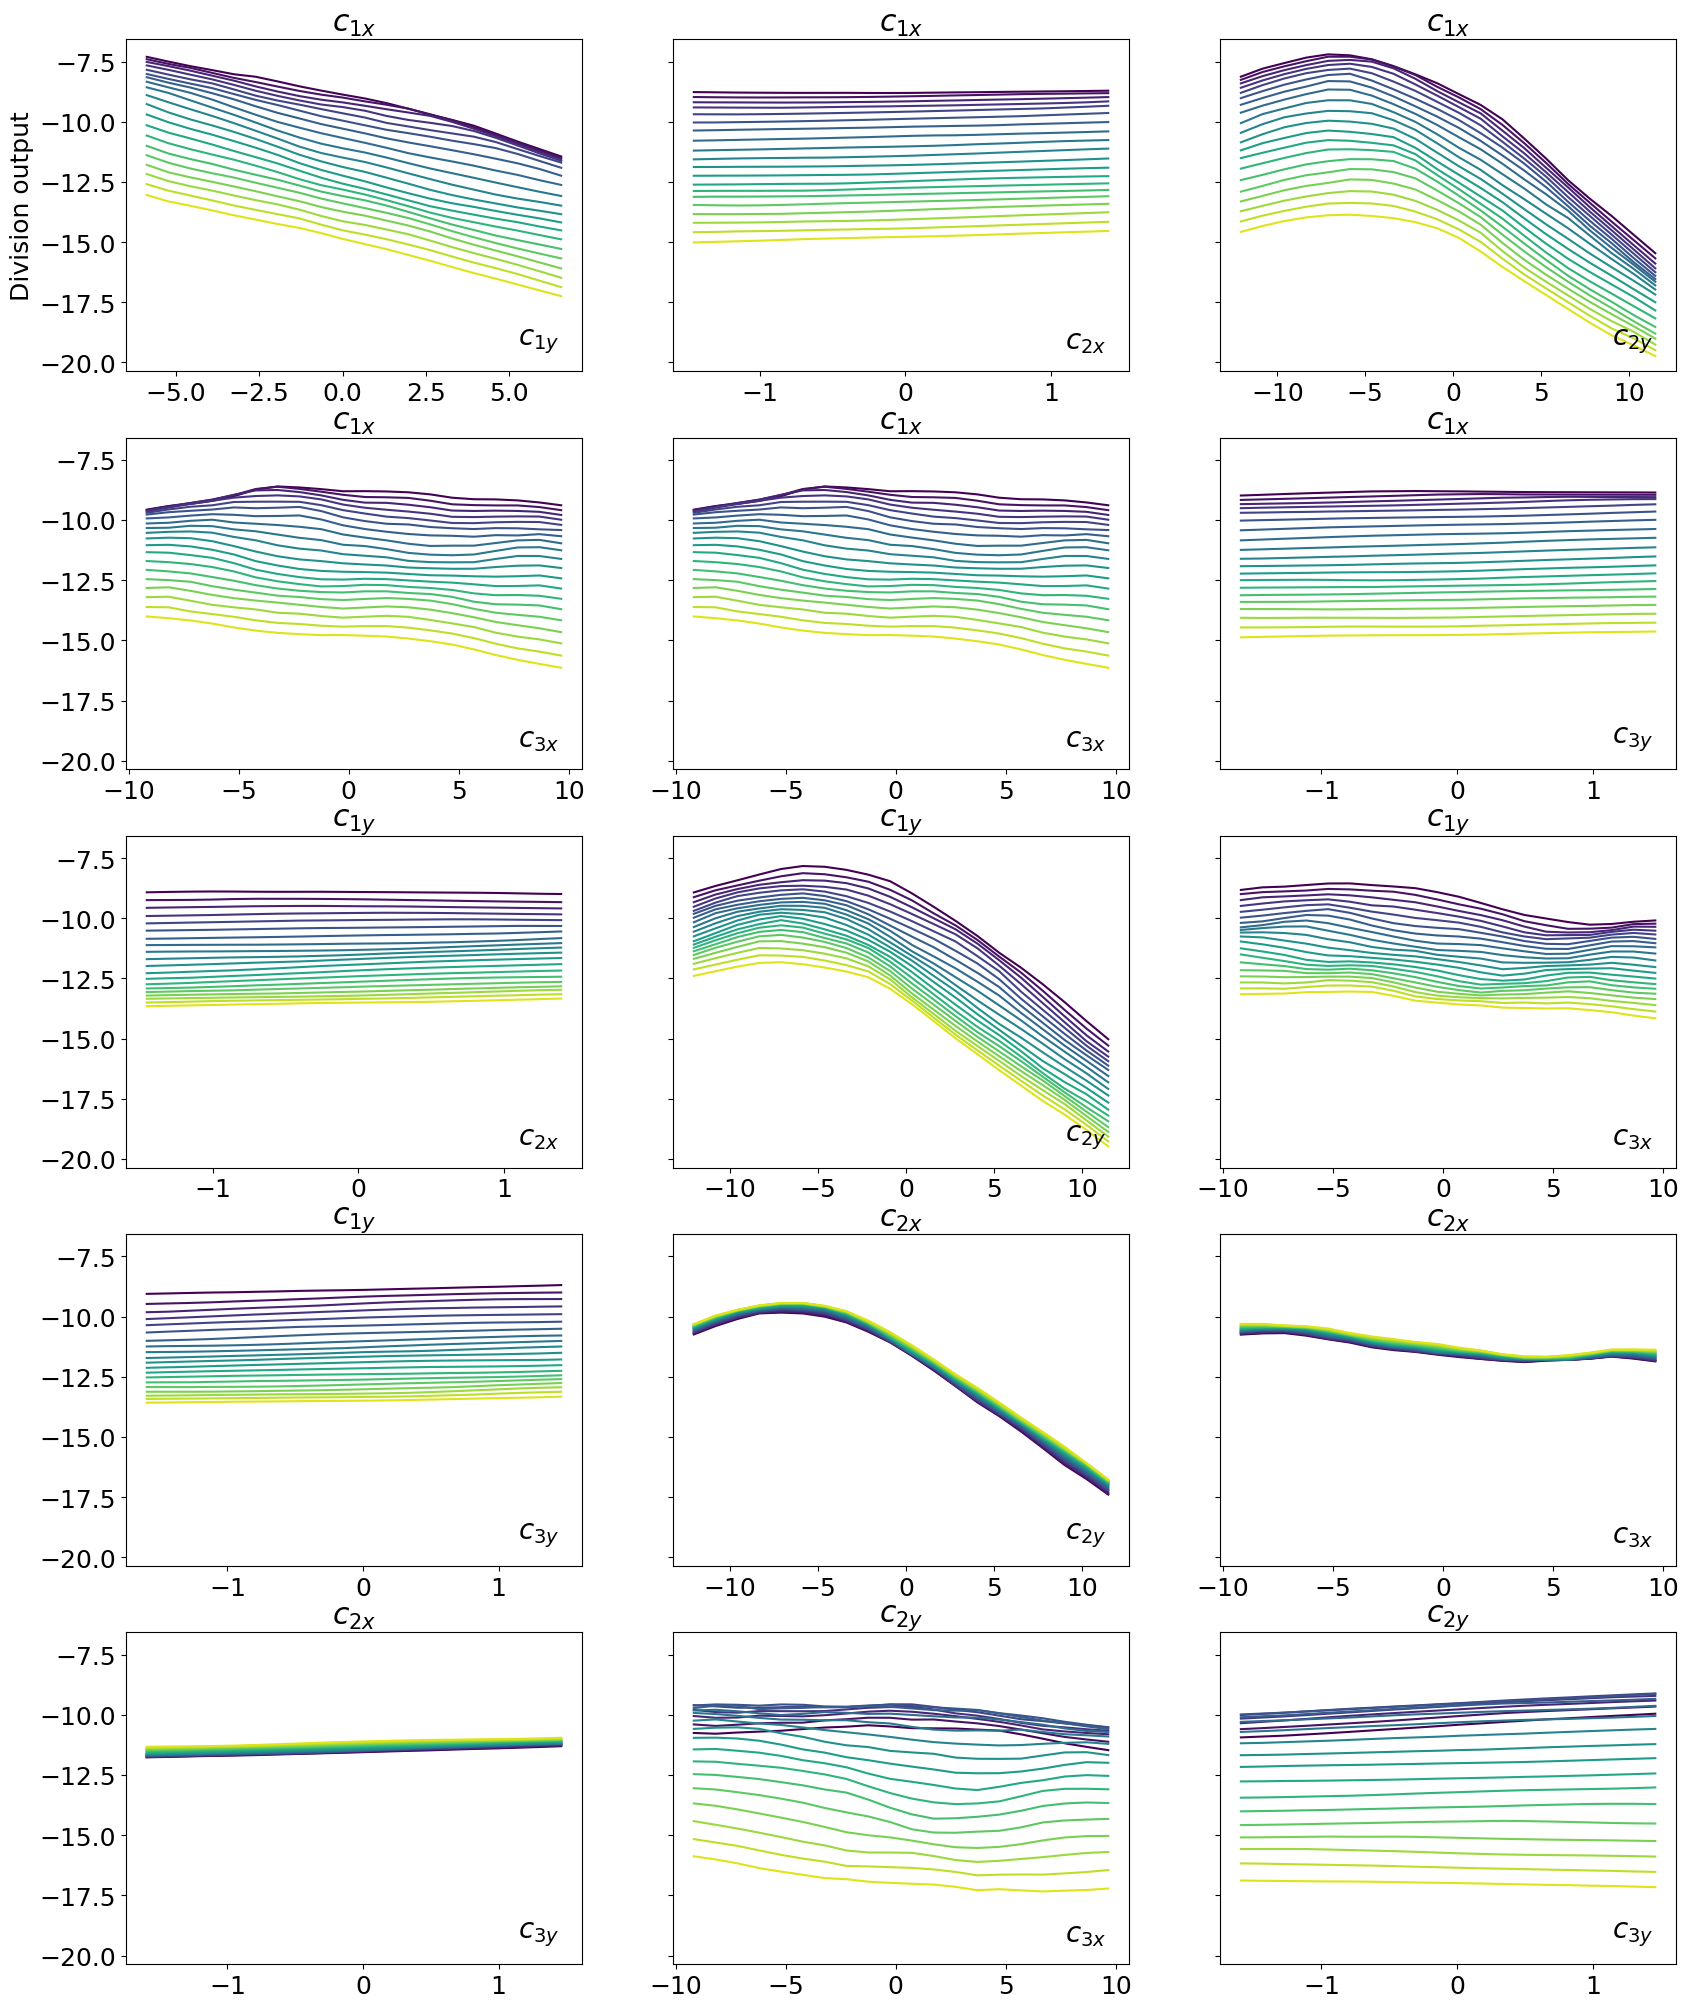

In [342]:
# Plot division network output for pairs of chemgrad inputs
fig, ax = plt.subplots(5, 3, figsize=(20, 25), sharey=True)
# Combinations of choosing two out of six  possible spots
combinations = np.array([[1, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0], [1, 0, 0, 1, 0, 0], 
                [1, 0, 0, 0, 1, 0], [1, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 1], 
                [0, 1, 1, 0, 0, 0], [0, 1, 0, 1, 0, 0], [0, 1, 0, 0, 1, 0], 
                [0, 1, 0, 0, 0, 1], [0, 0, 1, 1, 0, 0], [0, 0, 1, 0, 1, 0], 
                [0, 0, 1, 0, 0, 1], [0, 0, 0, 1, 1, 0], [0, 0, 0, 1, 0, 1], 
                [0, 0, 0, 0, 1, 1]])
labels = ["$c_{1x}$", "$c_{1y}$", "$c_{2x}$", "$c_{2y}$", "$c_{3x}$", "$c_{3y}$"]
for i in range(15):
    cellstate_template["chemgrad"] = np.array(combinations[i])
    cellstate_template["divrate"] = np.array([0.0])
    cellstate_template["chemical"] = np.array([0.0, 0.0, 0.0])
    (x, y), div_output = get_nn_output(traj_opt, use_state_fields, opt_param.copy(), cellstate_template, _div_nn, "div_fn")
    for j in range(20):
        ax[i//3, i%3].plot(y.T[j],  div_output.reshape(20, 20).T[j], c=plt.cm.viridis(j/20));
    idx = np.argwhere(combinations[i] > 0)
    ax[i//3, i%3].set_title(labels[idx[0][0]])
    # put text in lower right corner of the subplot
    ax[i//3, i%3].text(0.95, 0.05, labels[idx[1][0]], transform=ax[i//3, i%3].transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            color='black', fontsize=20)
    ax[0, 0].set_ylabel(r"Division output")
    plt.savefig('../data/paper/figures/vshape/division_network_mechanism3.svg')

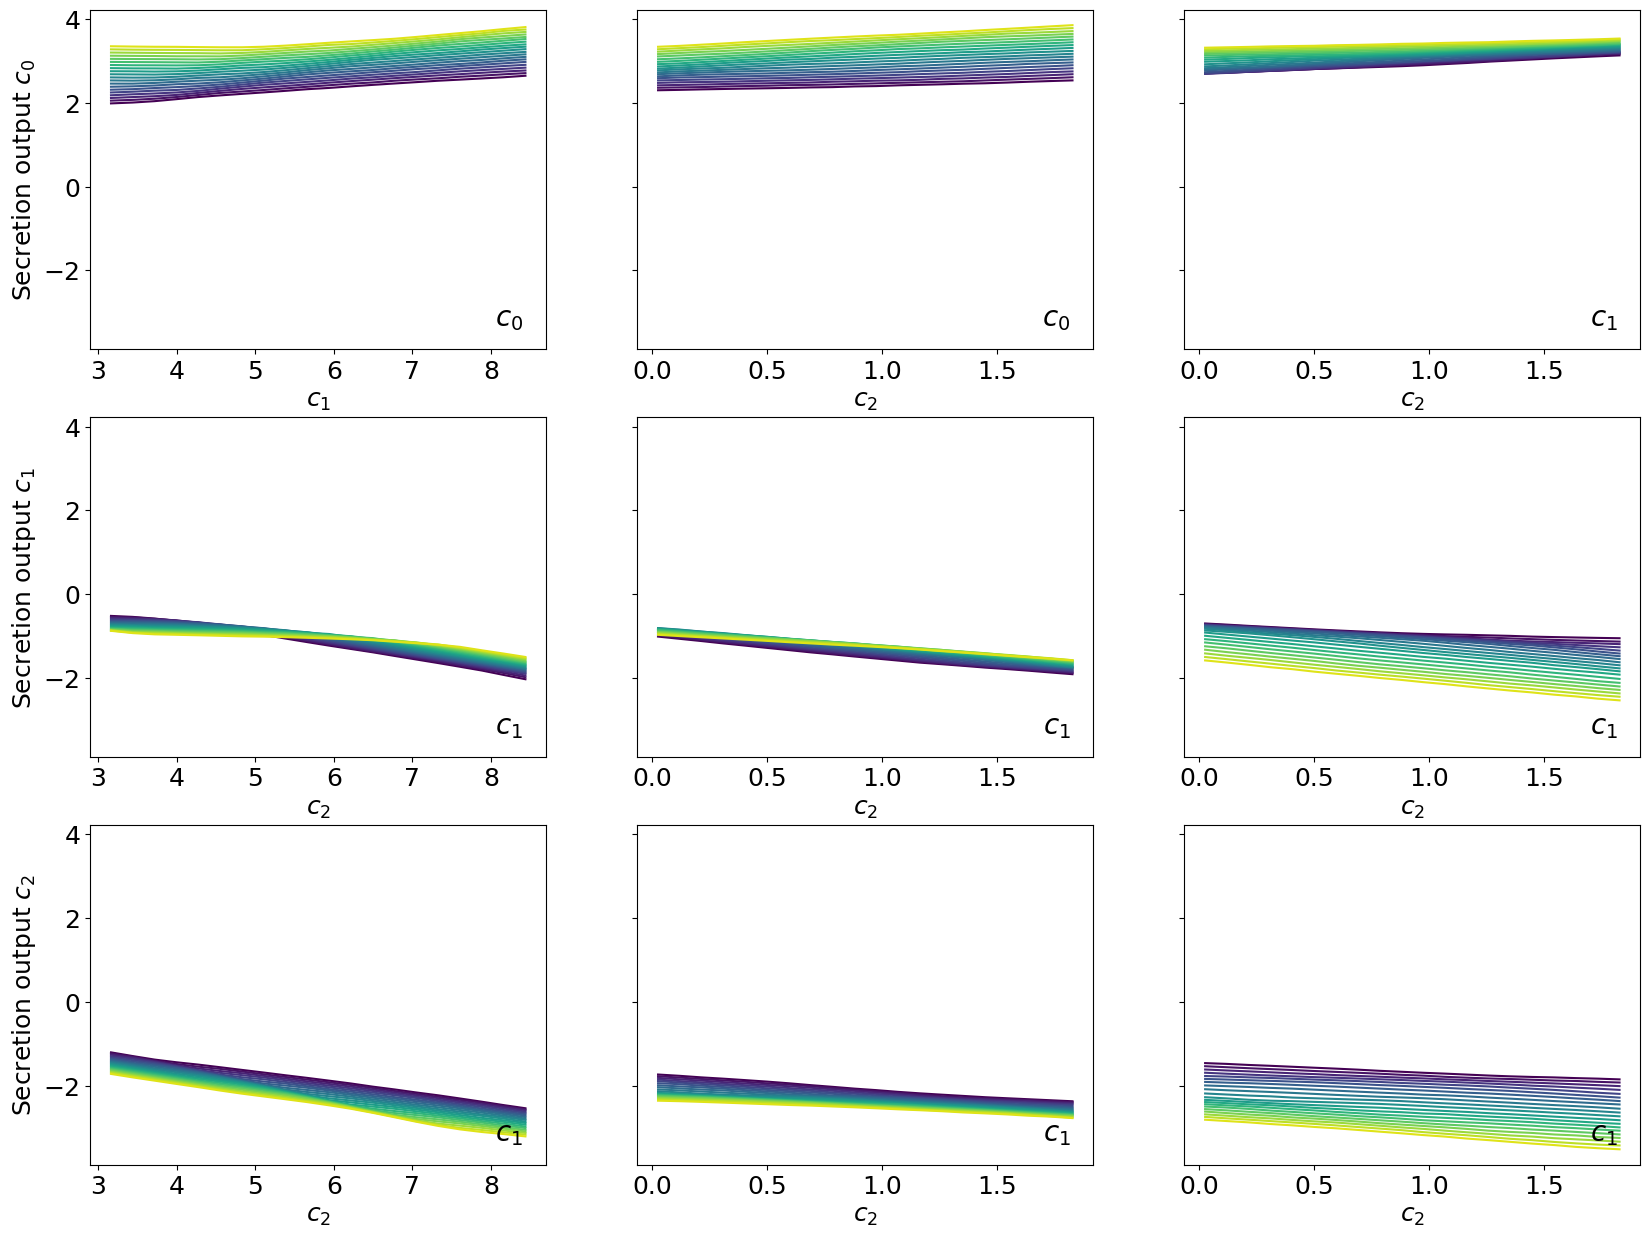

In [289]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15), sharey=True)
combinations = np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]])
for i in range(9):
    cellstate_template["chemical"] = np.array(combinations[i%3])
    cellstate_template["divrate"] = np.array([0.0])
    (x, y), sec_output = get_nn_output(traj_opt, use_state_fields, opt_param, cellstate_template, _sec_nn, "sec_fn")
    for j in range(20):
        ax[i//3, i%3].plot(y.T[j],  sec_output.reshape(20, 20, 3).T[i//3, j], c=plt.cm.viridis(j/20));
    idx = np.argwhere(combinations[i] > 0)
    #ax[i//3, i%3].set_title(r"$c_%s$" % idx[0][0])
    ax[i//3, i%3].set_xlabel(r"$c_%s$" % idx[1][0])
    # put text in lower right corner of the subplot
    ax[i//3, i%3].text(0.95, 0.05, r"$c_%s$" % idx[0][0], transform=ax[i//3, i%3].transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            color='black', fontsize=20)
    ax[i//3, 0].set_ylabel(r"Secretion output $c_%s$" % str(i//3))
plt.savefig('../data/paper/figures/vshape/secretion_network_mechanism.svg')

# Fitting synthetic network

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
### CREATE CELLSTATE DATASTRUCTURE ###
import jax_md
@jdc.dataclass
class CellState:
    '''
    Dataclass containing the system state.

    STATE
    -----

    '''

    # STATE
    position:   jax_md.util.Array
    celltype:   jax_md.util.Array
    radius:     jax_md.util.Array
    chemical:   jax_md.util.Array
    chemgrad:   jax_md.util.Array
    gene_vec:   jax_md.util.Array
    stress:     jax_md.util.Array
    divrate:    jax_md.util.Array
    key:        jax_md.util.Array


    @classmethod
    def default_init(cls, n_dim=2, n_chem=1, n_inputs=6, hidden_size=10):
        '''
        Intializes a CellState with no cells (empty data structures, with correct shapes).
        

        Parameters
        ----------
        n_dim: int
            Number of spatial dimensions.
        n_chem: int
            Number of chemical species.

        Returns
        -------
        CellState
        '''

        assert n_dim == 2 or n_dim == 3, 'n_dim must be 2 or 3'
        assert n_chem > 0 and isinstance(n_chem, int), 'n_chem must be a positive integer'
        
        defaultstate = {
            'position'  :   np.empty(shape=(0, n_dim),              dtype=np.float32),
            'celltype'  :   np.empty(shape=(0,),                    dtype=np.int8),
            'radius'    :   np.empty(shape=(0,),                    dtype=np.float32),
            'chemical'  :   np.empty(shape=(0, n_chem),             dtype=np.float32),
            'chemgrad'  :   np.empty(shape=(0, int(n_dim*n_chem)),  dtype=np.float32),
            # Size of gene vec: # of inputs, # of hidden genes, # of outputs (divisions, secretion)
            'gene_vec'  :   np.empty(shape=(0, hidden_size + n_inputs + n_chem + 1), dtype=np.float32),
            'stress'    :   np.empty(shape=(0,),       dtype=np.float32),
            'divrate'   :   np.empty(shape=(0,),                    dtype=np.float32),
            'key'       :   None,
        }


        return cls(**defaultstate)



In [23]:
## Initialize CellState
# import spacefunc
from jax_morph.datastructures import SpaceFunc
key = random.PRNGKey(0)
fspace = SpaceFunc(*space.free())
key, init_key = random.split(key)
Dparams, Dtrain_params = default_params(init_key, 2)
Dparams['hidden_state_size'] = 16
istate = CellState.default_init(n_dim=Dparams['n_dim'], 
                                    n_chem=Dparams['n_chem'],
                                    hidden_size=Dparams['hidden_state_size'],
                                    n_inputs=9)
# does init state grow use neural networks? Doesn't matter for when n_cells_init is small
istate = init_state_grow(init_key, istate, Dparams, fspace, Dparams["ncells_init"])

In [24]:
import jax
from jax import lax
def synnet(state, params, train_params, use_state_fields=None, train=True):

    if use_state_fields is None:
        raise ValueError('Input fields flags must be passed explicitly as a CellState dataclass.')
        
    def _circuit_solve(x0, n_steps, W, k, I, dt=.1):
        def _step(xt,t):
            x_dot = jax.nn.sigmoid(xt.dot(W))-k*xt+I
            xtt = xt + x_dot*dt
            return xtt, xtt
        x, _ = lax.scan(_step, x0, np.arange(n_steps))
        return x


    # Initialize gene interactions
    def init(state, key):     
        in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
        n_genes = in_fields.shape[1] + params["hidden_state_size"] + params["n_chem"] + 1
        # Initialize weights matrix for gene interactions of n_genes x n_genes
        p = np.zeros((n_genes, n_genes))#np.zeros((n_genes, n_genes))
        # Add to param dict
        params['gene_fn'] = p

        # no need to update train_params when generating initial state
        if type(train_params) is dict:
            #set trainability flag
            train_p = jax.tree_map(lambda x: train, p)
            train_params['gene_fn'] = train_p
            return params, train_params
        
        else:
            return params
            
        
    # Use gene interactions to update gene vector    
    def fwd(state, params):
        
        in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])
        #n_genes = params["n_sec_genes"] + params["n_int_genes"] + params["n_chem"]
        #n_cells = params["ncells_add"] + params["ncells_init"]
        #gene_vec = np.zeros((n_cells, params["n_sec_genes"] + params["n_int_genes"] + params["n_chem"]))
        #gene_vec = gene_vec.at[:, :params["n_sec_genes"]].set(in_fields)
        input_vec = np.hstack((in_fields, np.zeros((in_fields.shape[0], state.gene_vec.shape[1] - in_fields.shape[1]))))
        gene_vec = _circuit_solve(x0=state.gene_vec, n_steps=100, W=params['gene_fn'], k=1.0, I=input_vec)
        #sec = gene_vec[:, -params["n_chem"]:]*params['sec_max']
        # Update_gene_vec
        #state = state.at["gene_vec"].set(gene_vec)
        return gene_vec
        
    return init, fwd

In [25]:
def sec_fn(state, params):
    sec = state.gene_vec[:, -params["n_chem"]:]*params['sec_max']
    sec = sec*params['sec_max']
    ctype_sec_chem = np.vstack((np.zeros(params['n_chem']), params['ctype_sec_chem']))
    @vmap
    def sec_mask(ct):
        return ctype_sec_chem[np.int16(ct)] #change if we switch to dead cells = -1
        
    mask = sec_mask(state.celltype)
    return sec*mask
def div_fn(state, params):
    div = state.gene_vec[:, -params["n_chem"]-1]
    div = div*logistic(state.radius+.06, 50, params['cellRad'])
    div = np.where(state.celltype<1.,0,div)
    return div
def S_ss_gene_vec(state, params, fspace, syn_fun=None):
    gene_vec = syn_fun(state, params)
    state = jdc.replace(state, gene_vec=gene_vec)
    return state

In [26]:
use_state_fields = CellState(position=      False, 
                                celltype=      False, 
                                radius=            True, 
                                chemical=          True,
                                chemgrad=          True,
                                divrate=           True,
                                gene_vec=  False,
                                stress=    True,
                                key=           False
                                )
synnet_init, synnet_apply = synnet(istate, Dparams, Dtrain_params, use_state_fields)
p, tp = synnet_init(istate, key)

In [27]:
from jax_morph.chemicals.diffusion import diffuse_allchem_ss_exp, diffuse_allchem_ss
from jax_morph.mechanics import morse

### Simulation loop
fstep = [
        # ENV CHANGES
        S_cell_division,
        S_grow_cells,
        morse.S_mech_morse_relax,
        partial(S_ss_gene_vec, syn_fun=synnet_apply),
        partial(S_ss_chemfield, sec_fn=sec_fn, diffusion_fn=diffuse_allchem_ss, n_iter=1),
        # SENSING
        S_chemical_gradients,
        S_set_stress,
        # POLICIES
        partial(S_set_divrate, divrate_fn=eqx.filter_jit(div_fn))
    ]

In [28]:
from collections import namedtuple

SimulBlocks = namedtuple('SimulBlocks', ['fstep', 'fspace', 'istate', 'params', 'train_params'])
sim = SimulBlocks(fstep, fspace, istate, p, tp) 

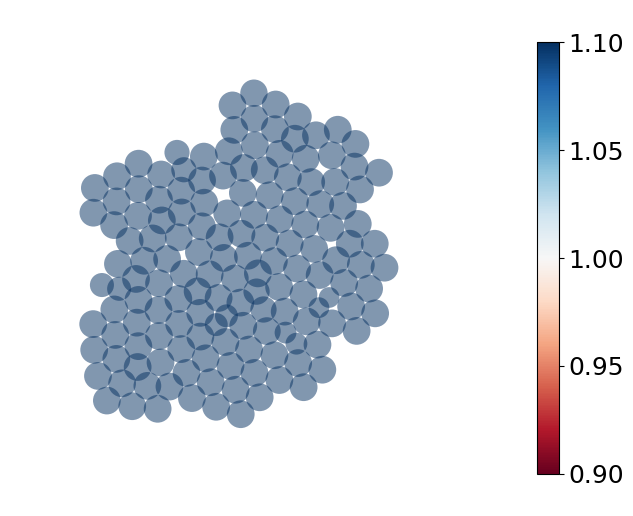

In [29]:
sim_init, sim_step = simulation(sim.fstep, sim.params, sim.fspace)
fstate, _ = sim_trajectory(sim.istate, sim_init, sim_step, sim.params["ncells_add"], key, history=False)
draw_circles(fstate, fstate.celltype, cm=plt.cm.RdBu);

In [30]:
# Regularized loss function
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def loss(params, 
         hyper_params,
         fstep,
         fspace,
         istate,
         sim_key=None,
         metric_fn=None,
         metric_type='reward',
         REINFORCE=True,
         GAMMA=.99,
         ncells_add=None,
         LAMBDA=0.0
         ):
    '''
    Reinforce loss on trajectory (with discounting). Rewards are differences in successive state metrics.

    If REINFORCE=False, then the loss is just the state measure on the final state.

    GAMMA is the discount factor for the calculation of the returns.

    If metric_type='reward', it is maximized, if metric_type='cost', it is minimized.

    '''

    #simulation length
    ncells_add = hyper_params['ncells_add'] if ncells_add is None else ncells_add
    
    def _sim_trajectory(istate, sim_init, sim_step, ncells_add, key=None):

        state = sim_init(istate, ncells_add, key)

        def scan_fn(state, i):
            state, logp = sim_step(state)
            measure = metric_fn(state)
            return state, (logp, measure)


        iterations = np.arange(ncells_add)
        fstate, aux = jax.lax.scan(scan_fn, state, iterations)

        return fstate, aux

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)

    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    _, (logp, measures) = _sim_trajectory(istate, sim_init, sim_step, ncells_add, sim_key)

    
    if REINFORCE:
        
        def _returns_rec(rewards):
            Gs=[]
            G=0
            for r in rewards[::-1]:
                G = r+G*GAMMA
                Gs.append(G)

            return np.array(Gs)[::-1]
        
        
        measures = np.append(np.array([metric_fn(istate)]),measures)
        
        if metric_type=='reward':
            rewards = np.diff(measures)
        elif metric_type=='cost':
            rewards = -np.diff(measures)


        returns = _returns_rec(rewards)

        # standardizing returns helps with convergence
        returns = (returns-returns.mean())/(returns.std()+1e-8)

        loss = -np.sum(logp*jax.lax.stop_gradient(returns))
        if LAMBDA > 0.:
            if "gene_fn" in params:
                loss += LAMBDA*np.abs(params["gene_fn"]).sum()
        return loss

    else:
        return measures[-1]

In [31]:
### OPTIMIZATION FUNCTION ###
from Francesco.ALIFE_plots.alife_utils import train
import optax
def run_optimization(train_key, 
                     sim,
                     metric_fn,
                     metric_type,
                     epochs=10, 
                     episodes_per_update=4, 
                     episodes_per_eval=64, 
                     learning_rate=1e-3, 
                     optimizer=optax.adam,
                     reinforce_gamma=.95,
                     save_every=10,
                     save_grads=False,
                     normalize_grads=True,
                     LAMBDA=0.0,
                     ):



    train_loss = eqx.filter_jit(partial(loss, metric_fn=metric_fn, metric_type=metric_type, REINFORCE=True, GAMMA=reinforce_gamma, LAMBDA=LAMBDA))
    eval_loss = eqx.filter_jit(partial(loss, metric_fn=metric_fn, REINFORCE=False, LAMBDA=LAMBDA))


    loss_t, params_t, grads_t = train(train_key, 
                                    epochs, 
                                    episodes_per_update, 
                                    episodes_per_eval, 
                                    learning_rate, 
                                    train_loss, 
                                    eval_loss,
                                    sim.fstep,
                                    sim.fspace,
                                    sim.istate,
                                    sim.params,
                                    sim.train_params,
                                    normalize_grads=normalize_grads,
                                    optimizer=optimizer,
                                    save_every=save_every,
                                    save_grads=save_grads,
                                    )
    
    return loss_t, params_t, grads_t


In [37]:
EPOCHS = 300
EPISODES_PER_UPDATE = 8
EPISODES_PER_EVAL = 64

LEARNING_RATE = 3e-2
# learning rate schedule
#LEARNING_RATE = optax.piecewise_constant_schedule(.05, {100: .1})
METRIC_FN = position_sum_of_squares

SAVE_EVERY = 1

key, train_key = random.split(key)
loss_t, params_t, _ = run_optimization(train_key,
                                       sim,
                                       METRIC_FN,
                                       metric_type='cost',
                                       epochs=EPOCHS,
                                       episodes_per_update=EPISODES_PER_UPDATE,
                                       episodes_per_eval=EPISODES_PER_EVAL,
                                       learning_rate=LEARNING_RATE,
                                       save_every=SAVE_EVERY,
                                       LAMBDA=0.1,
                                       )


Loss: 1.9585:  60%|████████████████▎          | 181/300 [08:43<05:44,  2.89s/it]

Interrupted


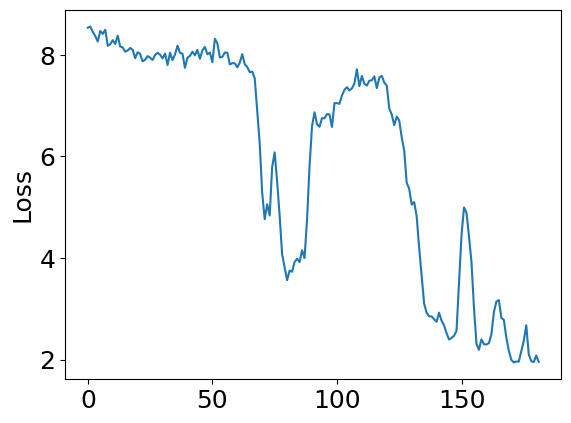

In [38]:
plt.plot(loss_t);
plt.ylabel("Loss");

In [45]:
# pruning threshold
import networkx as nx
eps = 0.12
W = np.where(np.abs(params_t[-1]["gene_fn"])>eps, params_t[-1]["gene_fn"], 0)

Text(0.5, 1.0, 'Synthetic gene network')

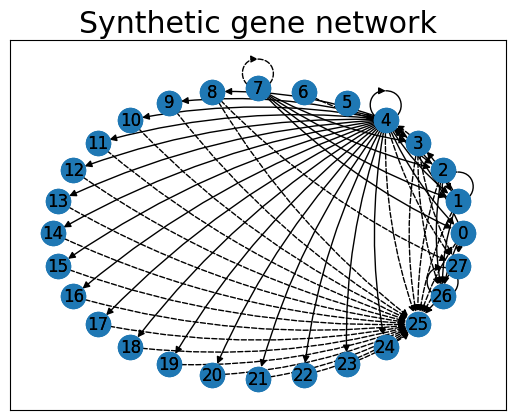

In [46]:
G = nx.from_numpy_array(W.T, create_using=nx.DiGraph)
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']>0])
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", style='--', edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']<0])
plt.title("Synthetic gene network")

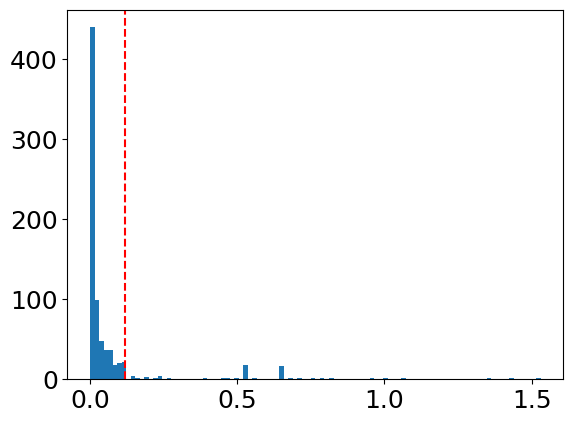

In [44]:
plt.hist(np.abs(params_t[-1]["gene_fn"]).flatten(), bins=100);
plt.axvline(0.12, linestyle='dashed', color='r')

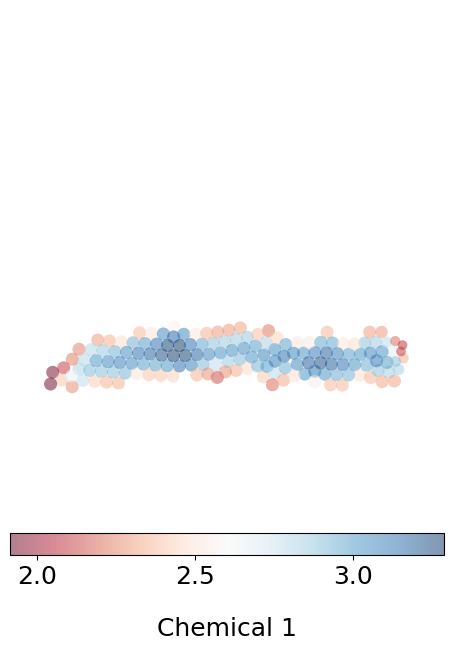

In [39]:
sim_init, sim_step = simulation(fstep, eqx.combine(params_t[-1], p), fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, p["ncells_add"], key, history=False)
draw_circles(fstate, fstate.chemical[:, 0], cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Chemical 1", normalize=False);

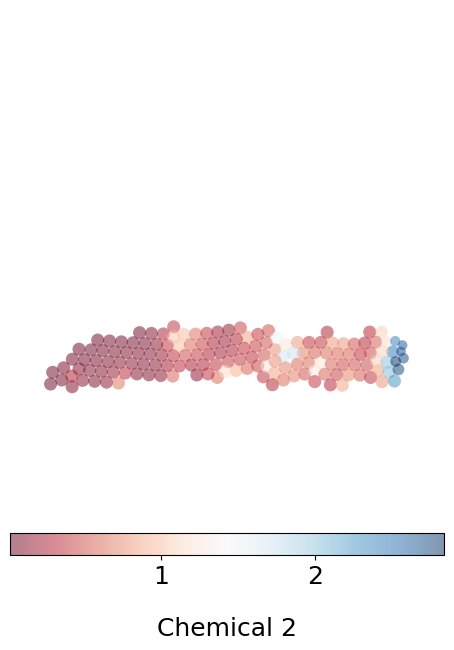

In [49]:
sim_init, sim_step = simulation(fstep, eqx.combine(params_t[-1], p), fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, p["ncells_add"], key, history=False)
draw_circles(fstate, fstate.chemical[:, 1], cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Chemical 2", normalize=False);

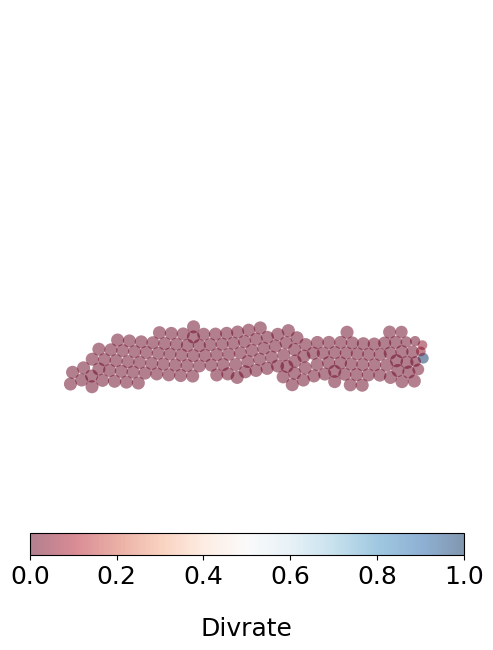

In [48]:
sim_init, sim_step = simulation(fstep, eqx.combine(params_t[-1], p), fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, p["ncells_add"], key, history=False)
draw_circles(fstate, fstate.divrate, cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Divrate", normalize=False);

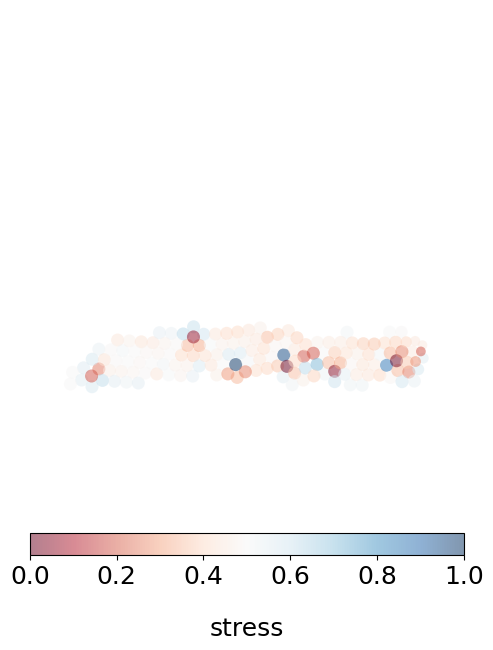

In [50]:
sim_init, sim_step = simulation(fstep, eqx.combine(params_t[-1], p), fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, p["ncells_add"], key, history=False)
draw_circles(fstate, fstate.stress, cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="stress", normalize=False);

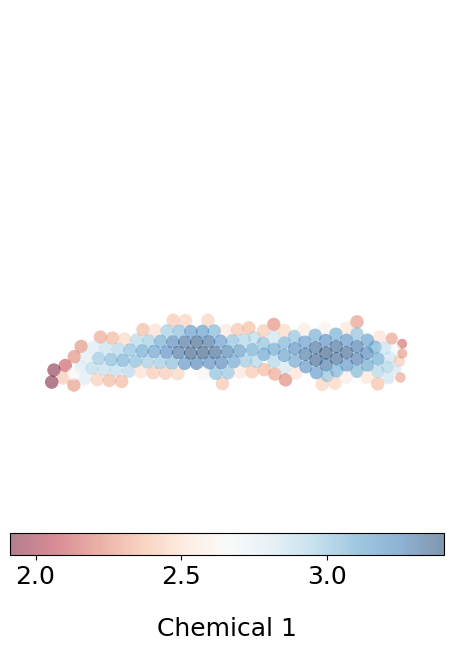

In [47]:
pruned_p = params_t[-1].copy()
pruned_p["gene_fn"] = np.where(np.abs(params_t[-1]["gene_fn"])>0.01, params_t[-1]["gene_fn"], 0)
sim_init, sim_step = simulation(fstep, eqx.combine(pruned_p, p), fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, p["ncells_add"], key, history=False)
draw_circles(fstate, fstate.chemical[:, 0], cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Chemical 1", normalize=False);

In [51]:
EPOCHS = 1000
EPISODES_PER_UPDATE = 10
EPISODES_PER_EVAL = 64

LEARNING_RATE = 2e-2

METRIC_FN = v_metric

SAVE_EVERY = 1

key, train_key = random.split(key)
loss_t, params_t, _ = run_optimization(train_key,
                                       sim,
                                       METRIC_FN,
                                       metric_type='reward',
                                       epochs=EPOCHS,
                                       episodes_per_update=EPISODES_PER_UPDATE,
                                       episodes_per_eval=EPISODES_PER_EVAL,
                                       learning_rate=LEARNING_RATE,
                                       save_every=SAVE_EVERY,
                                       LAMBDA=0.0,
                                       )


Loss: 32.9772:  54%|█████████████▍           | 536/1000 [26:01<22:31,  2.91s/it]

Interrupted


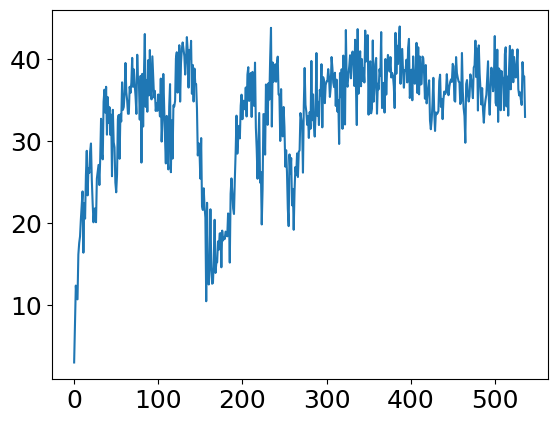

In [52]:
plt.plot(loss_t);

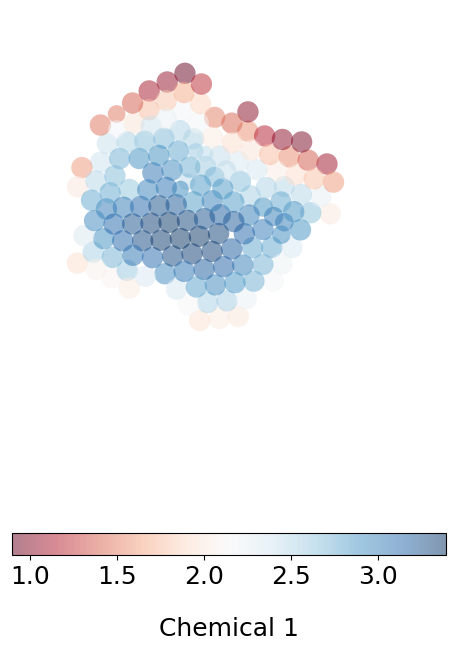

In [116]:
sim_init, sim_step = simulation(fstep, eqx.combine(params_t[-1], p), fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, p["ncells_add"], key, history=False)
draw_circles(fstate, fstate.chemical[:, 0], cm=plt.cm.RdBu, plt_cbar=True, orientation="horizontal", cbar_title="Chemical 1", normalize=False);